## Import all necessary modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bidi.algorithm import get_display
import unicodedata

## Enter coordinate list and radius in following format:
 - Coordinate list - lat,lon/lat,lon...
 - Radius = Positive number

In [43]:
print("Coordinate list - ")
coordinate_list = input()
print("Radius - ")
radius = input()
params = {"coordinate_list":coordinate_list,"radius":radius}

Coordinate list - 
32.058895,34.805781/32.058895,34.805791
Radius - 
150


## Calls the circle searcher api with the coordinate list and radius we inputed
  - If connection fails - returns failed to connect
  - If the api returned an error code then print output
  - If request returned a valid code - set the recieved payload in "data" and run calculations on it

In [44]:
try:
    current_request = requests.get("http://192.168.1.23:5000/api/circlesearcher",params)
    data = current_request.json()
    if not current_request.status_code == 200:
        print(data)
    else:
        print("Recieved data!")
        

except requests.ConnectionError:
    print("Failed to connect to api")

Recieved data!


## Calculates how many of each type are in the coordinate and returns a pandas DataFrame with the amount of each type, sorted in descending order

In [77]:
def calculate_type_amounts(current_coordinate):
    types_dictionary = {}
    for types in current_coordinate["types"]:
        for current_type in types:
            if current_type in types_dictionary:
                types_dictionary[current_type][0] += 1
            else:
                types_dictionary[current_type] = [1]
    types_df = pd.DataFrame.from_dict(types_dictionary,orient ='index',columns = ["amount"])
    types_df = types_df.sort_values(by="amount",ascending = False)
    return types_df

## Sets requested types in the coordinate dict
 - Takes the types requested by the user and sets a Dataframe with only the rows with each requested type
 - Orders the dict in the following way:
   - data_frame_dict[current_coordinate]["my_types"][current_type]:[data_frame] - Contains only location of requested type
   - Sorted by rating

In [25]:
def make_types_dictionary(data_frame_dict, my_types):
    #Remove duplicate types to decrese runtime
    my_types = list(dict.fromkeys(my_types))
    
    for coordinate in data_frame_dict:
        data_frame_dict[coordinate]["my_types"] = {}
        my_coordinate = data_frame_dict[coordinate]["locations"]

        for current_type in my_types:
            current_type_df = my_coordinate[my_coordinate["types"].apply(lambda location_types: current_type in location_types)]
            current_type_df = current_type_df.sort_values(by = "rating", ascending = False)
            data_frame_dict[coordinate]["my_types"][current_type] = current_type_df 
            
        
    return data_frame_dict

# Formulates my data in a master Data frame in the following way:
 - Takes selected types: my_types = [type1,type2...]
 - master_df = {coordinate: {locations: location_list_df, amount_of_each_type: df({type:amount...}),{my_types:{type1:df_of_type1...}}),
     
              coordinate2: ...}

In [26]:
def formulate_data(data_frame_dict, type_list):
    data_frame_dict = make_types_dictionary(data_frame_dict, type_list)
    for coordinate in data_frame_dict:
        types_df = calculate_type_amounts(data_frame_dict[coordinate]["locations"])
        data_frame_dict[coordinate]["amount_of_each_type"] = types_df
    master_df = pd.DataFrame.from_dict(data_frame_dict)
    return master_df

## Master cell - takes data, formulates it and runs all calculations - at the end plots data

Please enter desired types to check
park


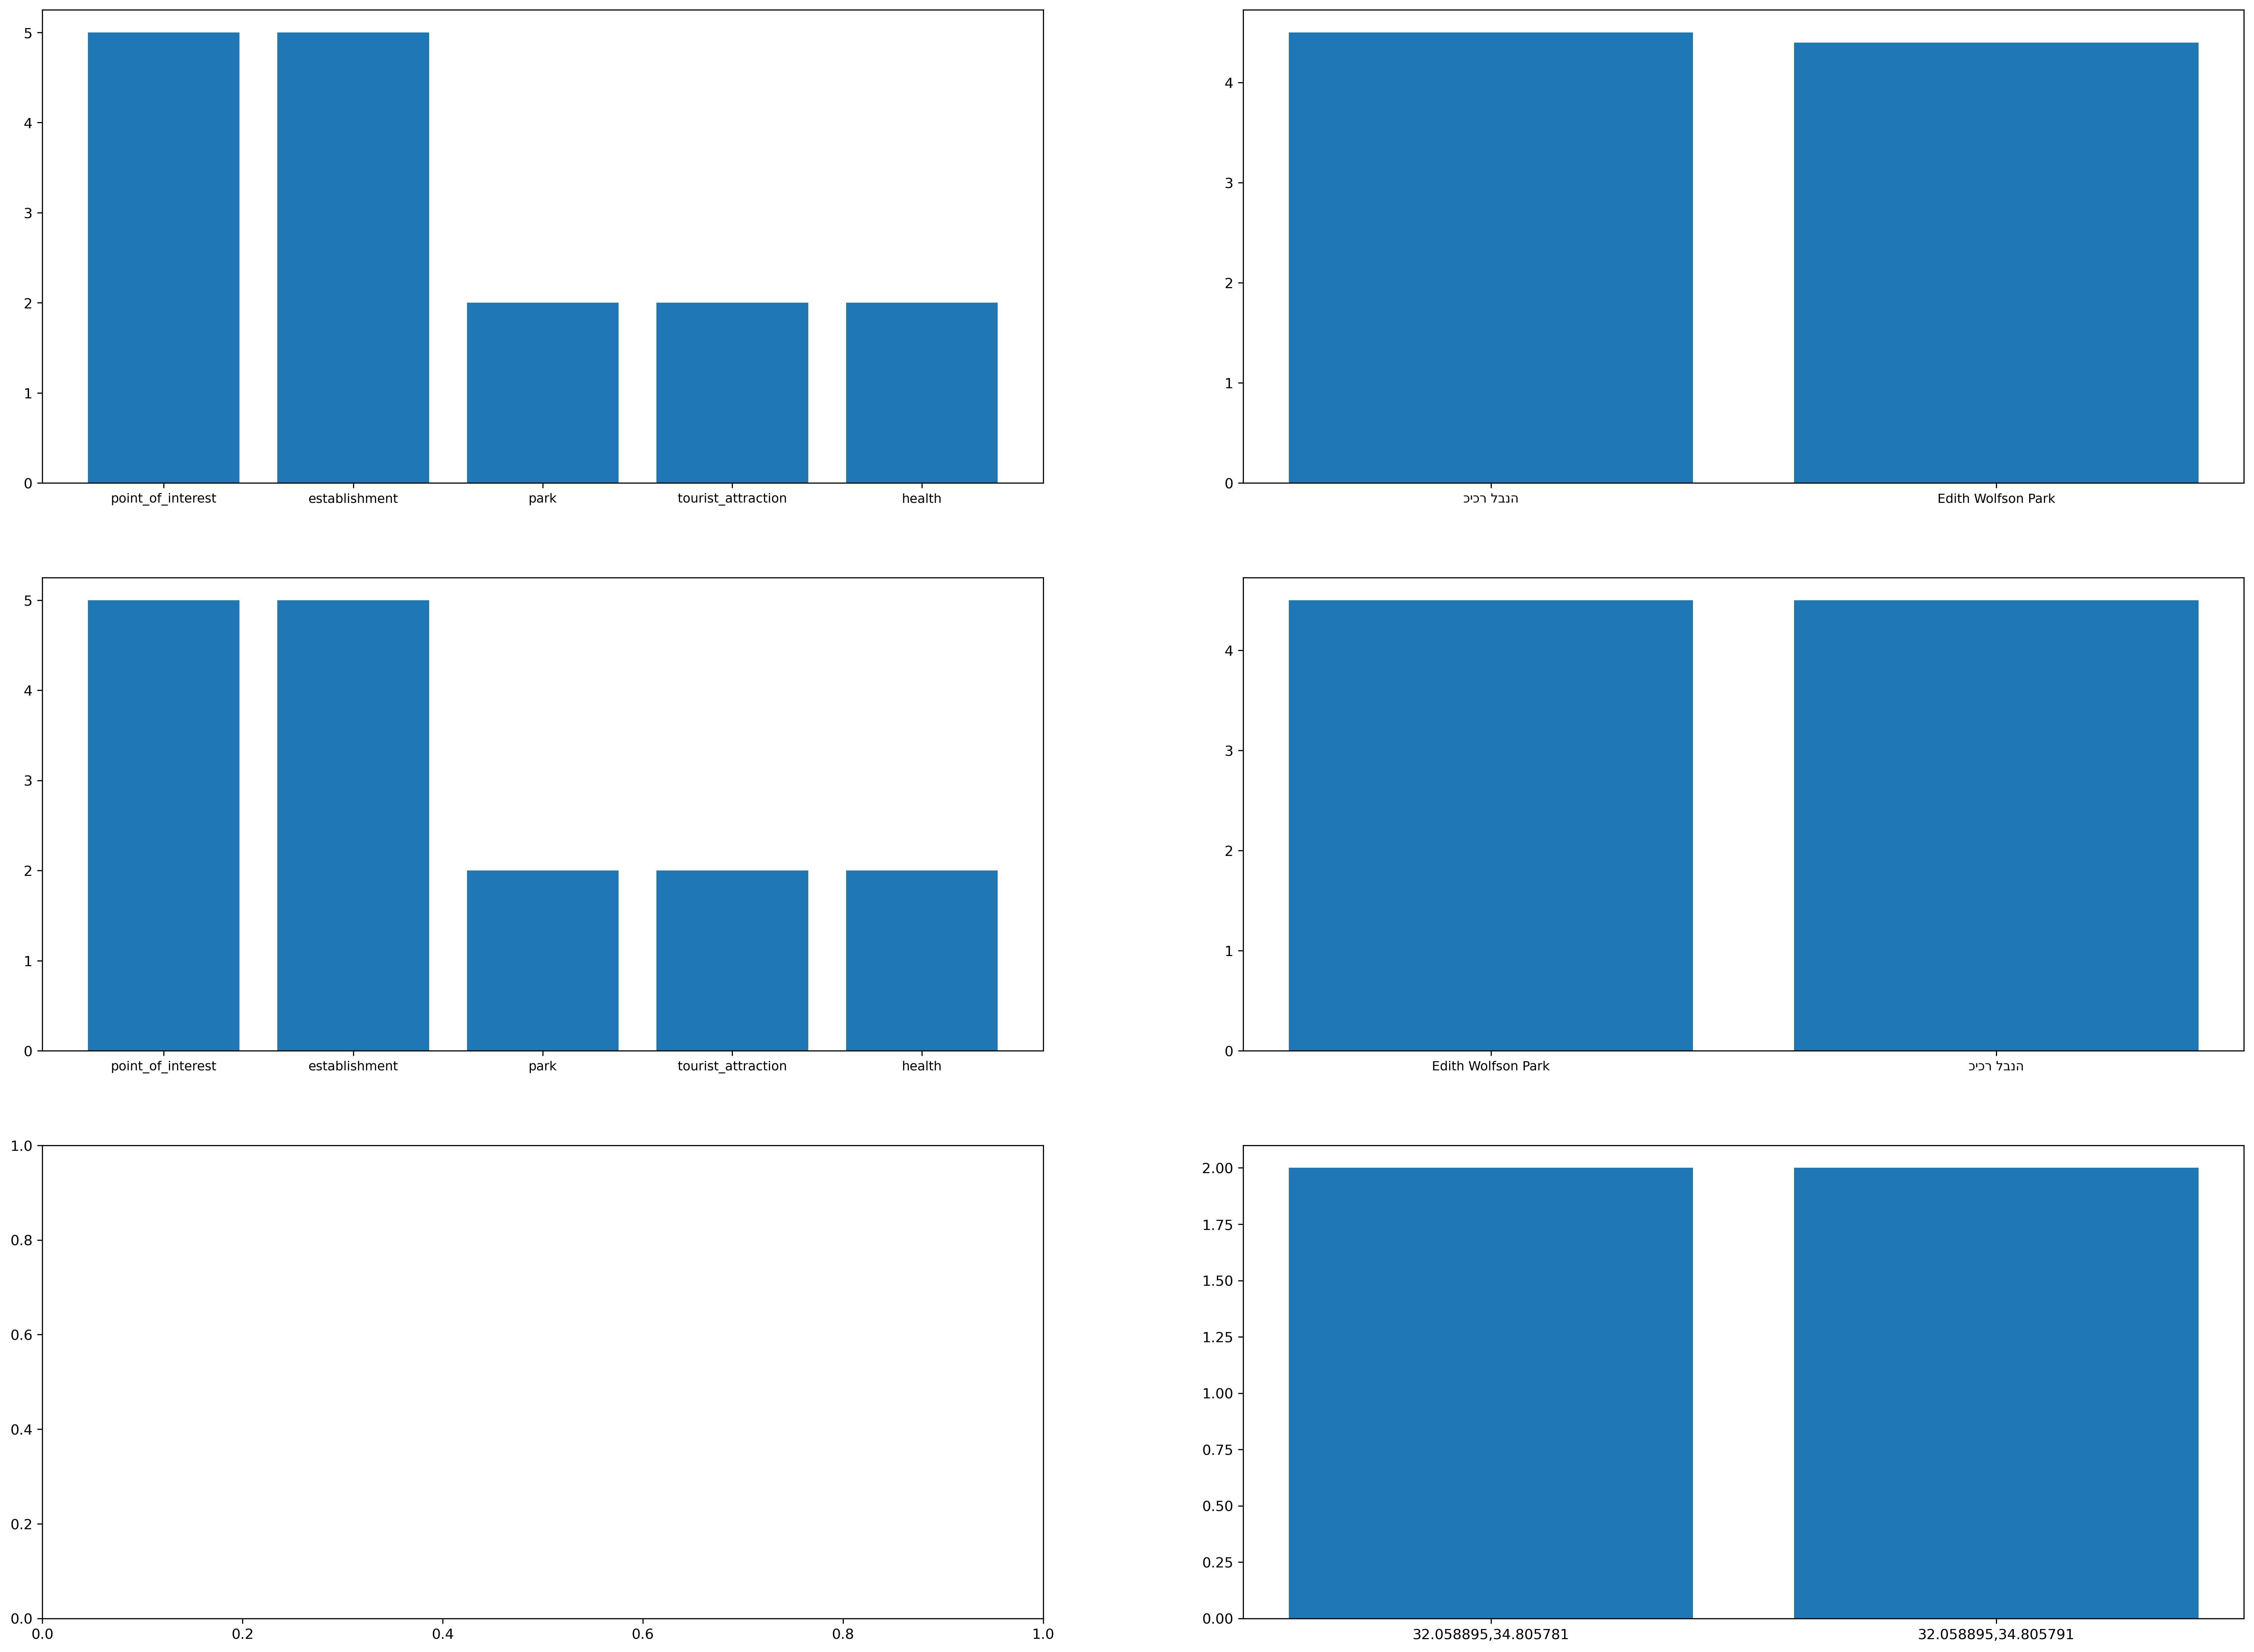

In [245]:
data_frame_dict = {}
for coordinate in data:
    my_data = data[coordinate]
    for location in my_data:
        name = location["name"]
        name = flip_hebrew_name(name)
        location["name"] = name
        if not "rating" in location:
            location["rating"] = 0
            location["user_ratings_total"] = 0
    my_coordinate = pd.DataFrame(data[coordinate])
    data_frame_dict[coordinate] = {"locations" : my_coordinate}

print("Please enter desired types to check")
my_types = input()
my_types = my_types.split(',')

master_df = formulate_data(data_frame_dict, my_types)
plot_data(master_df, my_types)

## Recieves an axes list a row and a column and returns an axes object

In [244]:
def get_axes(axes_list, row, column):
    current_axes = axes_list[row][column]
    return current_axes

## Function for plotting all coordinate data
 - Plot1: amount_of_each_type:
   - Plots a bar graph of am
   ounts by type
     - only plots top 10 types for space

In [243]:
def plot_data(master_df, my_types):
    
    
    #Calculates by amount of rows in each coordinate - 1: 1 axes for ammunt_of_types plus one axes for each type
    
    desired_column_amount = len(master_df.loc["my_types"][0]) + 1
    
    #Calculates desired row amount: 1 for each coordinate plus 1 master
    
    desired_row_amount = len(master_df.columns) + 1
    
    #Calculate figure size - multiply desired axes size (14*8) by the amount of rows and columns    

    figure_length = 14 * desired_column_amount
    figure_height = 7 * desired_row_amount
    data_figure, axes_list = plt.subplots(figsize=(figure_length,figure_height),dpi= 300,nrows = desired_row_amount,
                               ncols=desired_column_amount)
    
    
    current_row = 0
    for coordinate in master_df:
        coordinate_dict = master_df[coordinate]
        plot_coordinate(coordinate_dict, current_row, axes_list)
        current_row = current_row + 1
    
    plot_all_coordinates_by_types(master_df, my_types, current_row, axes_list)

In [242]:
def plot_coordinate(coordinate_dict, current_row, axes_list):
    current_coordinate = str(coordinate_dict.keys())
    current_column = 0
    current_ax = get_axes(axes_list, current_row, current_column)
    current_ax = plot_types_amount(coordinate_dict["amount_of_each_type"],current_ax)
    current_column = 1
    for current_type in coordinate_dict["my_types"]:
        current_ax = get_axes(axes_list, current_row, current_column)
        current_ax.set_title = "%s - %s - Highest rated"%(current_coordinate, current_type)
        current_ax = plot_type_by_rating(coordinate_dict["my_types"][current_type],current_ax)
        current_column += 1

In [241]:
def plot_types_amount(types_df,current_ax):
    types_df = types_df.head(5)
    types_list = types_df.index
    amounts = types_df["amount"]
    current_ax.bar(types_list,amounts)
    current_ax.tick_params(axis="x",labelsize = 9)
    return current_ax

In [240]:
def plot_type_by_rating(type_df, current_ax):
    type_df = type_df.head(5)
    name_list = type_df["name"]
    ratings_list = type_df["rating"]
    current_ax.bar(name_list, ratings_list)
    current_ax.tick_params(axis="x",labelsize = 9)
    return current_ax

In [239]:
def get_all_coordinates_amount_of_type(master_df, current_type):
    coordinate_list = list(master_df.columns)
    amount_list = []
    for coordinate in coordinate_list:
        amount_list.append(list(master_df[coordinate]["amount_of_each_type"].loc["park"]))
    type_amount_out_of_all = pd.DataFrame(amount_list, coordinate_list, columns = ["amount"])
    type_amount_out_of_all = type_amount_out_of_all.sort_values(by="amount",ascending = False)
    type_amount_out_of_all = type_amount_out_of_all.head(5)
    return coordinate_list, type_amount_out_of_all
    
def plot_all_coordinates_by_types(master_df, my_types, current_row, axes_list):
    current_column = 1
    for current_type in my_types:
        current_ax = get_axes(axes_list, current_row, current_column)
        coordinate_list, all_coordinates_current_type_amount = get_all_coordinates_amount_of_type(master_df, current_type)
        current_ax.bar(coordinate_list, list(all_coordinates_current_type_amount["amount"]))
        current_column += 1
    return current_ax

#plot_all_coordinates_by_types(master_df,["park"], "test",[")

# Function for flipping hebrew names in plot index so it prints them right to left
 - Iterates on the words in the name and checks if the first letter is in hebrew \n
   If it is - flips the letter order and the work order
 - Only functions properly on words that only have hebrew or english letters - 
   - If first letter is english - wont reverse hebrew
   - If first letter is hebrew - will reverse english

In [237]:
def is_hebrew(current_name):
    return 'HEBREW' in unicodedata.name(current_name.strip()[0])

def flip_hebrew_name(name):
    words = name.split(" ")
    
    for word in words:
        if is_hebrew(word):
            flipped_word = get_display(word)
            words[words.index(word)] = flipped_word
            
    words.reverse()        
    name = " ".join(words)
    return name